In [ ]:
using Pkg
Pkg.activate("../../env/.")
Pkg.instantiate()

## Use distributed computing

In [3]:
using Distributed

In [3]:
# print number of cores available
print(length(Sys.cpu_info()))

64

In [4]:
# add cores that I want to use
pids = addprocs(60);

In [5]:
# print number of cores actually used
nprocs()

61

In [4]:
include("../../src/analogous_bars.jl")
using .analogous_bars
using DelimitedFiles
using Measures
using Plots
@everywhere include("../../src/Eirene_var.jl")
@everywhere using .Eirene_var
@everywhere using Random
@everywhere using Distances
@everywhere using JLD2
@everywhere using PyCall
@everywhere using FileIO
@everywhere using Statistics


WebIO._IJuliaInit()

In [34]:
py"""
import numpy as np
from itertools import combinations

def limited_xcorr_neuron_spiketrain(raster1, neuron1, raster2, neuron2, limit_len):
    # compute limited xcorr score among two neurons
    # note: the two neurons can be in the same region or be in different regions

    # raster_1: V1 raster or AL raster
    # neuron_1: index of V1 neuron
    # raster2: V1 raster or AL raster
    # neuron2: index of AL neuron
    # return a similarity score between two neurons

    n_neurons_1, n_bins_1 = raster1.shape
    n_neurons_2, n_bins_2 = raster2.shape

    n_bins = n_bins_1
    if n_bins_1 != n_bins_2:
        print("Error. Number of bins in two rasters do not match")

    spikes1 = raster1[neuron1,:]
    spikes2 = raster2[neuron2,:]

    x_corr = np.correlate(spikes1, spikes2, 'full')

    # normalize
    norm_factor = np.sqrt(np.dot(spikes1, spikes1) * np.dot(spikes2, spikes2))

    corr_norm = [x / norm_factor for x in x_corr]

    score = sum(corr_norm[n_bins - limit_len: n_bins + limit_len + 1])
    return score


def limited_xcorr_aggregate_raster(raster, limit_len, scale_factor = None):
    # compute limited xcorr similarity and distance for neurons in one region (V1 or AL)

    # --- output ---
    # sim_score : array
    # distance : array
    # --------------
    n_neurons, n_bins = raster.shape
    xcorr_array = np.zeros((n_neurons, n_neurons))

    for (i, j) in combinations(range(n_neurons), 2):
        score = limited_xcorr_neuron_spiketrain(raster, i, raster, j, limit_len)

        xcorr_array[i, j] = score
        xcorr_array[j, i] = score

    if scale_factor == None:
        scale_factor = np.ceil(np.max(xcorr_array))

    xcorr_array_scaled = xcorr_array / scale_factor
    distance = 1 - xcorr_array_scaled
    np.fill_diagonal(distance, 0)

    return xcorr_array, distance
"""


In [30]:
# mean firing rate of 100 spikes 
@everywhere function generate_random_vector(N::Int, length::Int)
    if N > length
        error("N cannot be greater than the length of the vector")
    end
    
    # Create a vector with N ones and the rest zeros
    vector = vcat(ones(Int, N), zeros(Int, length - N))
    
    # Shuffle the vector to randomly distribute the 1s
    shuffle!(vector)
end

@everywhere function generate_random_raster(n_neurons, total_spikecount; n_bins  = 426)
    random_raster = zeros((n_neurons, n_bins))
    for i = 1:n_neurons
        random_vector = generate_random_vector(total_spikecount, n_bins)
        random_raster[i,:] = random_vector 
    end

    return random_raster
end

@everywhere function compute_random_spikes_PD(n_neurons, total_spikecount, output_dir, i)

    py"""
    import numpy as np
    from itertools import combinations

    def limited_xcorr_neuron_spiketrain(raster1, neuron1, raster2, neuron2, limit_len):
        # compute limited xcorr score among two neurons
        # note: the two neurons can be in the same region or be in different regions

        # raster_1: V1 raster or AL raster
        # neuron_1: index of V1 neuron
        # raster2: V1 raster or AL raster
        # neuron2: index of AL neuron
        # return a similarity score between two neurons

        n_neurons_1, n_bins_1 = raster1.shape
        n_neurons_2, n_bins_2 = raster2.shape

        n_bins = n_bins_1
        if n_bins_1 != n_bins_2:
            print("Error. Number of bins in two rasters do not match")

        spikes1 = raster1[neuron1,:]
        spikes2 = raster2[neuron2,:]

        x_corr = np.correlate(spikes1, spikes2, 'full')

        # normalize
        norm_factor = np.sqrt(np.dot(spikes1, spikes1) * np.dot(spikes2, spikes2))

        corr_norm = [x / norm_factor for x in x_corr]

        score = sum(corr_norm[n_bins - limit_len: n_bins + limit_len + 1])
        return score

    def limited_xcorr_aggregate_raster(raster, limit_len, scale_factor = None):
        # compute limited xcorr similarity and distance for neurons in one region (V1 or AL)

        # --- output ---
        # sim_score : array
        # distance : array
        # --------------
        n_neurons, n_bins = raster.shape
        xcorr_array = np.zeros((n_neurons, n_neurons))

        for (i, j) in combinations(range(n_neurons), 2):
            score = limited_xcorr_neuron_spiketrain(raster, i, raster, j, limit_len)

            xcorr_array[i, j] = score
            xcorr_array[j, i] = score

        if scale_factor == None:
            scale_factor = np.ceil(np.max(xcorr_array))

        xcorr_array_scaled = xcorr_array / scale_factor
        distance = 1 - xcorr_array_scaled
        np.fill_diagonal(distance, 0)

        return xcorr_array, distance
    """

    # generate random spike train
    random_raster = generate_random_raster(n_neurons, total_spikecount);

    # compute distances
    _, random_distance = py"limited_xcorr_aggregate_raster"(random_raster, 50, scale_factor = 33)

    C = eirene(random_distance, maxdim = 1)
    bc = barcode(C, dim = 1)

     # save
    save(output_dir * string(i) * ".jld2", "random_barcode", bc)
end

Load data

In [5]:
# load pkl data
py"""
import pickle
 
def load_pickle(fpath):
    with open(fpath, "rb") as f:
        data = pickle.load(f)
    return data
"""

load_pickle = py"load_pickle"

PyObject <function load_pickle at 0x7fd452e73f60>

In [6]:
# load raster
AL_raster = load_pickle("data/AL_st_raster.pkl")["stimulus_1"]
V1_raster = load_pickle("data/V1_st_raster.pkl")["stimulus_1"];

# load indices (Python indices)
V1_idx = readdlm("data/V1_neurons_idx.txt", '\t', Int, '\n')
AL_idx = readdlm("data/AL_neurons_idx.txt", '\t', Int, '\n');

V1_idx_python = vcat(V1_idx...)
AL_idx_python = vcat(AL_idx...);
V1_idx_julia = [i+1 for i in V1_idx_python]
AL_idx_julia = [i+1 for i in AL_idx_python]

V1_raster_small = V1_raster[V1_idx_julia,:,:]
AL_raster_small = AL_raster[AL_idx_julia,:,:];

# spike trains (aggregate raster)
V1_aggregate_small = sum(V1_raster_small, dims = 3)[:,:,1]
AL_aggregate_small = sum(AL_raster_small, dims = 3)[:,:,1];

# Example random spike trains

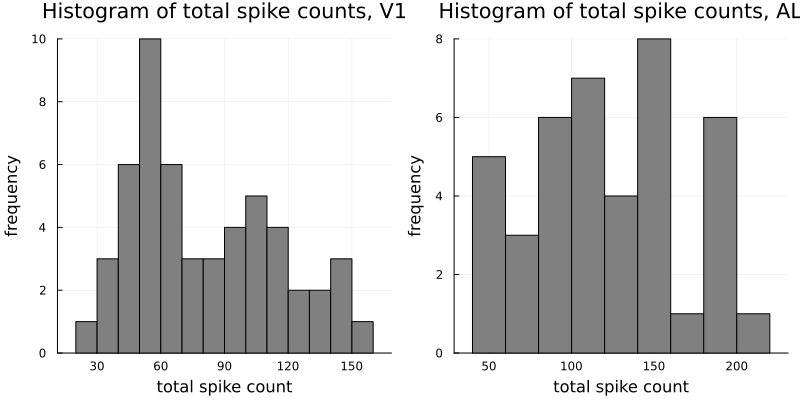

In [158]:
n_total_spikes_V1 = sum(V1_aggregate_small, dims = 2);
n_total_spikes_AL = sum(AL_aggregate_small, dims = 2);
p1 = histogram(n_total_spikes_V1, bins = 15, labels= "", c = "grey",
        xlabel = "total spike count", ylabel = "frequency", title = "Histogram of total spike counts, V1")
p2 = histogram(n_total_spikes_AL, bins = 15, labels= "", c = "grey",
        xlabel = "total spike count", ylabel = "frequency", title = "Histogram of total spike counts, AL")
plot(p1, p2, size = (800, 400), left_margin = 3mm, bottom_margin = 3mm, top_margin = 4mm)
#savefig("PD_significance_experiments/random_spikes/histograms_total_spikecount.pdf")


In [159]:
println("Average total spike count per neuron (V1) : ", mean(n_total_spikes_V1))
println("Standard deviation (V1): ", std(n_total_spikes_V1))
println("\nAverage total spike count per neuron (AL): ", mean(n_total_spikes_AL))
println("Standard deviation (AL): ", std(n_total_spikes_AL))

Average total spike count per neuron (V1) : 80.94339622641509
Standard deviation (V1): 33.86932756613708

Average total spike count per neuron (AL): 120.1951219512195
Standard deviation (AL): 46.909604300289686


In [160]:
n_neurons = 53
total_spikecount = 81
random_raster = generate_random_raster(n_neurons, total_spikecount);

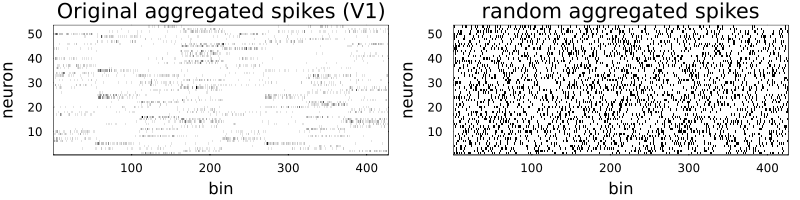

In [161]:
p1 = heatmap(V1_aggregate_small, size = (800, 200), colorbar = :none, frame = :box, c = :binary,
        xlabel = "bin", ylabel = "neuron",
        left_margin = 3mm, bottom_margin = 5mm, top_margin = 2mm, title = "Original aggregated spikes (V1)")


p2 = heatmap(random_raster, c = :binary, colorbar = :none, frame = :box, size = (800, 200), xlabel = "bin", ylabel = "neuron",
        left_margin = 3mm, bottom_margin = 5mm, top_margin = 2mm, title = "random aggregated spikes")

plot(p1, p2)
#savefig("PD_significance_experiments/random_spikes/example_random_spiketrains.pdf")

In [162]:
# compute distances
_, shuffled_distance = py"limited_xcorr_aggregate_raster"(random_raster, 50,  scale_factor = 33)

([0.0 18.08641975308642 … 17.716049382716058 17.740740740740748; 18.08641975308642 0.0 … 18.28395061728396 18.50617283950618; … ; 17.716049382716058 18.28395061728396 … 0.0 19.716049382716054; 17.740740740740748 18.50617283950618 … 19.716049382716054 0.0], [0.0 0.4519266741488963 … 0.46315001870557404 0.46240179573512885; 0.4519266741488963 0.0 … 0.4459408903853346 0.4392068836513279; … ; 0.46315001870557404 0.4459408903853346 … 0.0 0.4025439580995135; 0.46240179573512885 0.4392068836513279 … 0.4025439580995135 0.0])

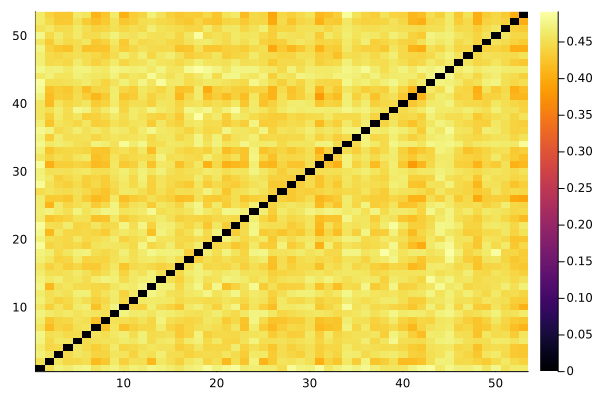

In [163]:
heatmap(shuffled_distance)

In [164]:
C = eirene(shuffled_distance, maxdim = 1)
bc = barcode(C, dim = 1)
bc[:,2] - bc[:,1]

7-element Vector{Float64}:
 0.0026187803965582734
 0.004863449307893841
 0.00411522633744843
 0.0037411148522257243
 0.006359895248784331
 0.0007482229704454113
 0.0007482229704450782

# Generate random spike trains

In [37]:
total_spikecount = 73
n_neurons = 41
output_dir = "PD_significance_experiments/random_spikes/spikecount_" * string(total_spikecount) *  "_neurons_" * string(n_neurons) * "/"
isdir(output_dir) || mkdir(output_dir)

"PD_significance_experiments/random_spikes/spikecount_73_neurons_41/"

In [38]:
@distributed for i=1:1000
    compute_random_spikes_PD(n_neurons, total_spikecount, output_dir, i)
end

Task (runnable) @0x00007fdf56f02d60

In [ ]:
# kill all processes 
interrupt()

In [42]:
# collect all lifetimes
lifetimes = []
n_neurons = 41
total_spikecounts = [73, 120, 167]

for i = 1:1000
    for sc in total_spikecounts
        output_dir = "PD_significance_experiments/random_spikes/spikecount_" * string(sc) *  "_neurons_" * string(n_neurons) * "/"
        # open julia files
        random_barcode = FileIO.load(output_dir * string(i) * ".jld2")["random_barcode"]
        append!(lifetimes, random_barcode[:,2] - random_barcode[:,1])
    end
end

In [43]:
print("maximum lifetime from random barcodes: ", maximum(lifetimes))


maximum lifetime from random barcodes: 0.018679950186799577

In [45]:
histogram(lifetimes, labels = "", xlabel = "lifetime", ylabel = "frequency", title = "histogram of lifetimes from random spike trains (V1)")
#savefig("PD_significance_experiments/random_spikes/histogram_AL.pdf")

"/home/hyoon/analogous_neural/analysis/experimental_visual/PD_significance_experiments/random_spikes/histogram_AL.pdf"

Maximum lifetime from random spiketrains (spikecounts 47, 81, 115): 0.02256

Maximum lifetime from random spiketrains (spikecount 120):  0.01868

Plot the original PD from V1 and AL with the threshold

In [5]:
# load dissimilarity
total_D = readdlm("data/total_dissimilarity.csv")

# get number of neurons in AL
AL_txt = open("data/AL_neurons_idx.txt", "r")
AL_linebyline = readlines(AL_txt)
close(AL_txt)
n_AL = size(AL_linebyline, 1)

# get number of neurons in V1
V1_txt = open("data/V1_neurons_idx.txt", "r")
V1_linebyline = readlines(V1_txt)
close(V1_txt)
n_V1 = size(V1_linebyline, 1)

# Define submatrices 
D_V1 = total_D[1:n_V1, 1:n_V1]
D_AL = total_D[n_V1+1:end, n_V1+1:end]
D_V1_AL = total_D[1:n_V1, n_V1+1:end]
    # rows (landmarks): V1
    # columns (witness) : AL
D_AL_V1 = total_D[n_V1+1:end, 1:n_V1];
    # rows (landmarks): AL
    # columns (witness) : V1

In [6]:
# compute persistence diagrams 
C_V1 = eirene(D_V1, record = "all", maxdim = 1)
C_AL = eirene(D_AL, record = "all", maxdim = 1)

barcode_V1 = Eirene_var.barcode(C_V1, dim = 1)
barcode_AL = Eirene_var.barcode(C_AL, dim = 1)


2×2 Matrix{Float64}:
 0.381433  0.386574
 0.456083  0.508385

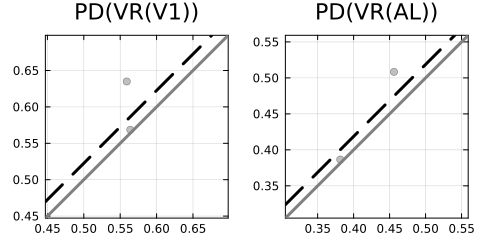

In [51]:
# plot persistence diagrams
p1 = plot_PD(barcode_V1, title = "PD(VR(V1))", titlefontsize = 15, cutoff = 0.02256)
p2 = plot_PD(barcode_AL, title = "PD(VR(AL))", titlefontsize = 15, cutoff = 0.01868)
plot(p1, p2, layout = grid(1,2), size = (480, 250))
#savefig("PD_significance_experiments/random_spikes/PD_with_threshold_from_randomspikes.pdf")

In [76]:
# plot persistence diagrams
p1 = plot_PD(barcode_V1, title = "PD(V1)",  pd_min = 0.55, pd_max = 0.65, markersize = 5, diagonal_lw = 2, threshold_lw = 2, titlefontsize = 12, cutoff = 0.02256)
p2 = plot_PD(barcode_AL, title = "PD(AL)", pd_min = 0.35, pd_max = 0.52, markersize = 5, diagonal_lw = 2, threshold_lw = 2, titlefontsize = 12, cutoff = 0.01868)
plot(p1, p2, layout = grid(1,2), size = (480, 250))
#savefig("PD_significance_experiments/random_spikes/PD_with_threshold_from_randomspikes_scaled.pdf")

"/home/hyoon/analogous_neural/analysis/experimental_visual/PD_significance_experiments/random_spikes/PD_with_threshold_from_randomspikes_scaled.pdf"

# Heterogeneity of spike counts of neurons leads to almost empty persistence diagrams for randomly shuffled / randomly generated spike trains 

* When we randomly shuffle the spike times of each neuron, thereby preserving the total number of spikes in each neuron, the neurons with high number of spikes, let's call this n_high, becomes "equally close" to all other neurons. 
* This is like having a conal point on a cone. So we have a contractible space, and we are unlikely to observe nontrivial points on persistence diagrams.

In [28]:
function generate_random_raster_varying_spikecounts(n_neurons, n_total_spikes; n_bins  = 426)
    random_raster = zeros((n_neurons, n_bins))
    for i = 1:n_neurons
        random_vector = generate_random_vector(Int64(n_total_spikes[i]), n_bins)
        random_raster[i,:] = random_vector 
    end

    return random_raster
end

generate_random_raster_varying_spikecounts (generic function with 1 method)

In [165]:
random_raster = generate_random_raster_varying_spikecounts(53, n_total_spikes_V1, n_bins = 426);

In [166]:
# compute distances
_, shuffled_distance = py"limited_xcorr_aggregate_raster"(random_raster, 50, scale_factor = 33)

([0.0 13.172332342547554 … 13.19763002617791 11.05324844750339; 13.172332342547554 0.0 … 17.754129938174067 15.362071772027363; … ; 13.19763002617791 17.754129938174067 … 0.0 14.431312815377865; 11.05324844750339 15.362071772027363 … 14.431312815377865 0.0], [0.0 0.6008384138621954 … 0.6000718173885482 0.665053077348382; 0.6008384138621954 0.0 … 0.4619960624795737 0.5344826735749284; … ; 0.6000718173885482 0.4619960624795737 … 0.0 0.562687490443095; 0.665053077348382 0.5344826735749284 … 0.562687490443095 0.0])

In [167]:
C = eirene(shuffled_distance, maxdim = 1)
bc = barcode(C, dim = 1)
bc[:,2] - bc[:,1]

Float64[]

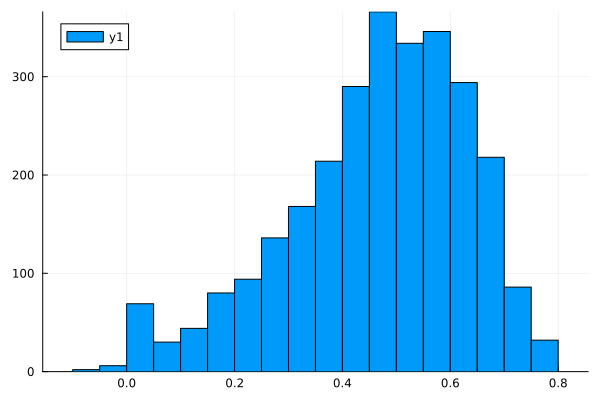

In [168]:
histogram(vec(shuffled_distance))

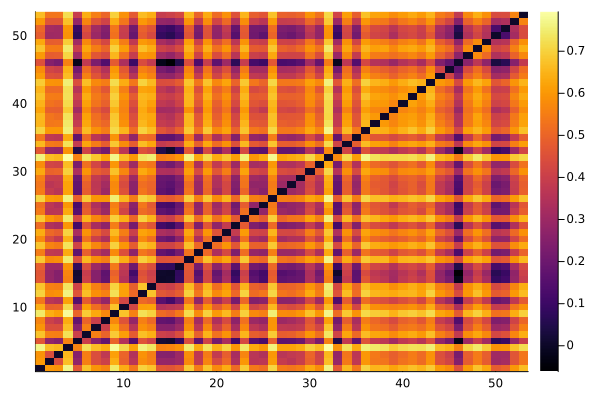

In [169]:
heatmap(shuffled_distance)

Looking at the distance heatmap, there are a few neurons, specifically 14, 15, 16, 46, 50, 51 that have "low dissimialrity" to all neurons, acting like "conal points"

In [170]:
# for each neuron, compute the average dissimilarity to all others
shuffled_distance

53×53 Matrix{Float64}:
 0.0       0.600838  0.591969  0.768699  …  0.500064   0.600072  0.665053
 0.600838  0.0       0.443917  0.668331     0.317227   0.461996  0.534483
 0.591969  0.443917  0.0       0.65576      0.309964   0.461521  0.534314
 0.768699  0.668331  0.65576   0.0          0.594646   0.673235  0.721786
 0.466826  0.275223  0.250289  0.561155     0.0940364  0.281965  0.395625
 0.674714  0.556355  0.55204   0.727459  …  0.449409   0.56572   0.638922
 0.592951  0.444618  0.444011  0.667135     0.311495   0.459447  0.553297
 0.562589  0.405008  0.375765  0.635511     0.247563   0.41066   0.500707
 0.742916  0.638554  0.615161  0.785241     0.535175   0.636891  0.697098
 0.639773  0.492521  0.498599  0.715015     0.396723   0.535171  0.587783
 0.536937  0.362503  0.346179  0.617443  …  0.208891   0.375614  0.474137
 0.701614  0.580464  0.588446  0.762666     0.492511   0.601954  0.662559
 0.676546  0.555307  0.549058  0.735416     0.458518   0.564442  0.638801
 ⋮             

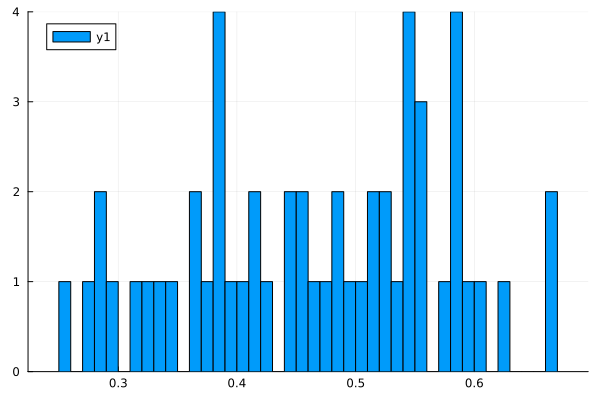

In [171]:
mean_dissimilarity = vec(mean(shuffled_distance, dims = 1));
histogram(mean_dissimilarity, bins = 50)

In [175]:
low_dissimilarity_idx = partialsortperm(mean_dissimilarity, 1:10, rev=false);

In [176]:
include_idx = [i for i = 1: length(mean_dissimilarity) if i ∉ low_dissimilarity_idx];

In [177]:
C = eirene(shuffled_distance[include_idx, include_idx], maxdim = 1)
bc = barcode(C, dim = 1)
bc[:,2] - bc[:,1]

Float64[]

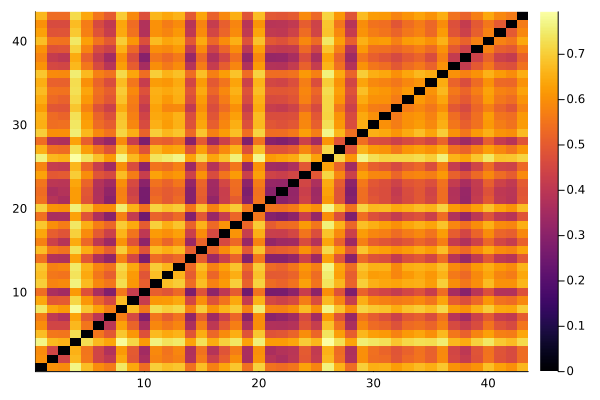

In [178]:
heatmap(shuffled_distance[include_idx, include_idx])

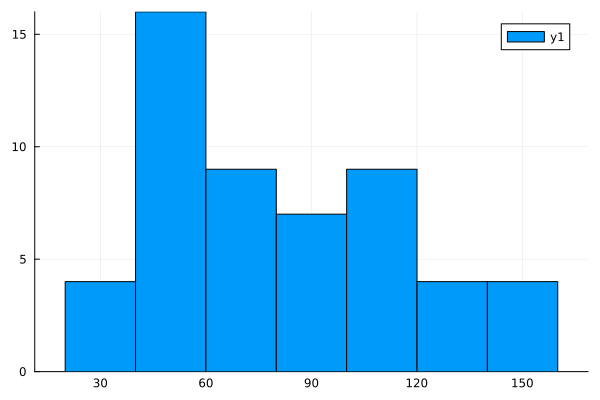

In [182]:
histogram(n_total_spikes_V1)

In [ ]:
# plot example high dissimilarity and low dissimilarity 

Actually, even after I remove such "conal points", I get trivial PD1

# plot the PD significance according to bootstrapping

* See R code "PD_confidence_sets.md"
* threshold, for V1, according to bootstrapping: 0.1428
* threshold, for AL, according to bootstrapping: 0.0622
* Note: these thresholds are already "persistence thresholds", not "distance thresholds". So one doesn't have to double the threshold when plotting the dotted line.

In [12]:
# plot persistence diagrams
p1 = plot_PD(barcode_V1, title = "PD(V1)", titlefontsize = 15, markersize = 7, cutoff =  0.1428)
p2 = plot_PD(barcode_AL, title = "PD(AL)", titlefontsize = 15, markersize = 7, cutoff = 0.0622)
plot(p1, p2, layout = grid(1,2), size = (480, 250))
#savefig("PD_significance_experiments/bootstrap_thresholds.pdf")

"/home/hyoon/analogous_neural/analysis/experimental_visual/PD_significance_experiments/bootstrap_thresholds.pdf"

# Random spikes using homogeneous poisson process

# Random spikes, where spike counts are sampled from the normal distribution

In [15]:
using Distributions, Random

[ Info: Precompiling DistributionsTestExt [ffbe0ea5-a612-5ff7-aaf5-cac02eef3019]


In [104]:
println("Average total spike count per neuron (V1) : ", mean(n_total_spikes_V1))
println("Standard deviation (V1): ", std(n_total_spikes_V1))
println("\nAverage total spike count per neuron (AL): ", mean(n_total_spikes_AL))
println("Standard deviation (AL): ", std(n_total_spikes_AL))

Average total spike count per neuron (V1) : 80.94339622641509
Standard deviation (V1): 33.86932756613708

Average total spike count per neuron (AL): 120.1951219512195
Standard deviation (AL): 46.909604300289686


In [105]:
V1_spikecount_distribution = Normal(mean(n_total_spikes_V1), std(n_total_spikes_V1))

Normal{Float64}(μ=80.94339622641509, σ=33.86932756613708)

In [106]:
sampled_V1 = rand(V1_spikecount_distribution, 53);
sampled_V1 = round.(sampled_V1, digits=0);

In [107]:
random_raster = generate_random_raster_varying_spikecounts(53, sampled_V1, n_bins = 426);

In [108]:
# compute distances
_, shuffled_distance = py"limited_xcorr_aggregate_raster"(random_raster, 50, scale_factor = 33)

([0.0 8.861469461982091 … 12.615621785844668 11.145178329663453; 8.861469461982091 0.0 … 16.009215573462427 13.085664499161489; … ; 12.615621785844668 16.009215573462427 … 0.0 21.758479106855766; 11.145178329663453 13.085664499161489 … 21.758479106855766 0.0], [0.0 0.731470622364179 … 0.6177084307319798 0.6622673233435317; 0.731470622364179 0.0 … 0.5148722553496234 0.6034647121466216; … ; 0.6177084307319798 0.5148722553496234 … 0.0 0.340652148277098; 0.6622673233435317 0.6034647121466216 … 0.340652148277098 0.0])

In [109]:
C = eirene(shuffled_distance, maxdim = 1)
bc = barcode(C, dim = 1)
bc[:,2] - bc[:,1]

Float64[]